<div style="text-align: center;">
<img src='lab3_title.png'/>
</div>

# ЛР-3 ММО в АСОИУ (Методы машинного обучения в АСОИУ)

**ИУ5-22М Кириллов Д.С. Вариант 7**

06.04.2024


## Цель лабораторной работы

Изучение продвинутых способов предварительной обработки данных для дальнейшего формирования моделей.


## Задание

1. Выбрать один или несколько наборов данных (датасетов) для решения следующих задач. Каждая задача может быть решена на отдельном датасете, или несколько задач могут быть решены на одном датасете. Просьба не использовать датасет, на котором данная задача решалась в лекции.
2. Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
    1. масштабирование признаков (не менее чем тремя способами);
    2. обработка выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);
    3. обработка по крайней мере одного нестандартного признака (который не является числовым или категориальным);
    4. отбор признаков:
        1. один метод из группы методов фильтрации (filter methods);
        2. один метод из группы методов обертывания (wrapper methods);
        3. один метод из группы методов вложений (embedded methods).

## Ход работы


### П.1. Подготовка датасета

#### Датасет Demographic and Socio-economic Indicators

Для пунктов 2.1 и 2.2 взял датасет **Demographic and Socio-economic Indicators - last update: September 2023** https://uis.unesco.org/bdds

В нем собраны различные социально-демографические и экономические метрики с разных стран по годам.

- INDICATOR_ID - код социально-демографической или экономической метрики. Категориальный признак.
- COUNTRY_ID - код государства. Категориальный признак.
- YEAR - год. Категориальный признак.
- VALUE	- значение этой социально-демографической или экономической метрики. Числовой признак.
- MAGNITUDE - пустая колонка
- QUALIFIER - пустая колонка

За некоторые года некоторые метрики могут быть пропущены. Это связано с тем, что расчеты по некоторым показателям не могли быть проведены из-за отсутствия данных. Либо эти данных никто не собирал, как в некоторых странах стретьего мира, либо эти страны имеют закрытую экономику, как Иран и КНДР. Однако, это нельзя считать полноценными пропусками. Если за такой-то год данные по такой-то метрике не были собраны, строка с такой страной, годом и метрикой просто будет отсутствовать. 

Также существует проблема, что данные о стране А собираются с 1900 года, а о стране Б - с 2000.

Для полноценного анализа, **исходный датасет нужно разбить** на более мелкие датасеты либо по исследуемой социально-демографической или экономической метрике, либо по стране.

В работе **буду искусственно внедрять пропуски**. Это проще, чем учитывать, что в такой-то из 241 стран в такой-то год произошли такие-то события, и потому данные за этот год можно считать пропуском.

#### Датасет рестораны

Предыдущий датасет не содержит категориальных признаков кроме страны и года. Страна уже закодирована числовым кодом. Год также представлен числом. Поэтому для п.2.3 и п.2.4. я взял другой датасет **Restaurant dataset with details** https://www.kaggle.com/datasets/mohdshahnawazaadil/restaurant-dataset

Он интересен тем, что колонка *Cuisines* содержит строку с видами кухни, перечисленных через запятую вида 'French, Japanese, Desserts', 'Seafood, Asian, Filipino, Indian', 'Sushi', т.е. нестандартный признак.

In [164]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
import scipy.stats as stats
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel

%matplotlib inline

In [165]:
data_folder = '../data/'
countries_labels = pd.read_csv(data_folder + 'DEM_COUNTRY.csv')
indicator_labels = pd.read_csv(data_folder + 'DEM_LABEL.csv')
data_raw = pd.read_csv(data_folder + 'DEM_DATA_NATIONAL.csv')

In [166]:
data_raw

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER
0,200101,ABW,1970,5.924000e+01,NaN,NaN
1,200101,ABW,1971,5.897300e+01,NaN,NaN
2,200101,ABW,1972,5.866000e+01,NaN,NaN
3,200101,ABW,1973,5.905100e+01,NaN,NaN
4,200101,ABW,1974,5.968000e+01,NaN,NaN
...,...,...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10,NaN,NaN
303305,XTGOV.IMF,ZWE,2020,1.726850e+11,NaN,NaN
303306,XTGOV.IMF,ZWE,2021,5.583440e+11,NaN,NaN
303307,XTGOV.IMF,ZWE,2022,2.329145e+12,NaN,NaN


Есть строки с большим количеством NaN. Узнаем, есть ли среди них полезные.

In [167]:
data_raw[~data_raw['MAGNITUDE'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


In [168]:
data_raw[~data_raw['QUALIFIER'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


Полезных нет. Эти 2 колонки можно удалить

In [169]:
df = data_raw.dropna(axis='columns', how='all')
df

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE
0,200101,ABW,1970,5.924000e+01
1,200101,ABW,1971,5.897300e+01
2,200101,ABW,1972,5.866000e+01
3,200101,ABW,1973,5.905100e+01
4,200101,ABW,1974,5.968000e+01
...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10
303305,XTGOV.IMF,ZWE,2020,1.726850e+11
303306,XTGOV.IMF,ZWE,2021,5.583440e+11
303307,XTGOV.IMF,ZWE,2022,2.329145e+12


In [170]:
def two_lists_to_dict(keys, values):
  res = {}
  for key in keys:
      for value in values:
          res[key] = value
          values.remove(value)
          break
  return res

countries_labels = countries_labels.to_dict('list')
countries_labels = two_lists_to_dict(countries_labels['COUNTRY_ID'], countries_labels['COUNTRY_NAME_EN'])

indicator_labels = indicator_labels.to_dict('list')
indicator_labels = two_lists_to_dict(indicator_labels['INDICATOR_ID'], indicator_labels['INDICATOR_LABEL_EN'])


In [171]:
print(f'Число стран: {len(countries_labels)} | Число показателей: {len(indicator_labels)}')

Число стран: 241 | Число показателей: 35


In [172]:
indicator_labels

{'200101': 'Total population (thousands)',
 '200144': 'Population aged 15-24 years (thousands)',
 '200151': 'Population aged 65 years or older (thousands)',
 '200343': 'Population aged 14 years or younger (thousands)',
 '200345': 'Population aged 25-64 years (thousands) ',
 'DT.TDS.DECT.GN.ZS': 'Total debt service (% of GNI)',
 'NY.GDP.DEFL.ZS': 'GDP deflator (base year varies by country)',
 'NY.GDP.MKTP.CD': 'GDP (current US$)',
 'NY.GDP.MKTP.CN': 'GDP (current LCU)',
 'NY.GDP.MKTP.KD  ': 'GDP at market prices (constant 2010 US$)',
 'NY.GDP.MKTP.KD.ZG': 'GDP growth (annual %)',
 'NY.GDP.MKTP.KN': 'GDP (constant LCU)',
 'NY.GDP.MKTP.PP.CD': 'GDP, PPP (current international $)',
 'NY.GDP.MKTP.PP.KD': 'GDP, PPP (constant 2011 international $)',
 'NY.GDP.PCAP.CD': 'GDP per capita (current US$)',
 'NY.GDP.PCAP.CN': 'GDP per capita (current LCU)',
 'NY.GDP.PCAP.PP.CD': 'GDP per capita, PPP (current international $)',
 'NY.GDP.PCAP.PP.KD': 'GDP per capita, PPP (constant 2011 international $)

### П.2.1. Масштабирование признаков
(не менее чем тремя способами)

Возьму выборку "Продолжительность жизни всех стран, лет". Предполагаю, что целевой признак уже отделен от данной выборки

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE
0,SP.DYN.LE00.IN,ABW,1970,67.583
1,SP.DYN.LE00.IN,ABW,1971,67.975
2,SP.DYN.LE00.IN,ABW,1972,68.577
3,SP.DYN.LE00.IN,ABW,1973,69.092
4,SP.DYN.LE00.IN,ABW,1974,69.503


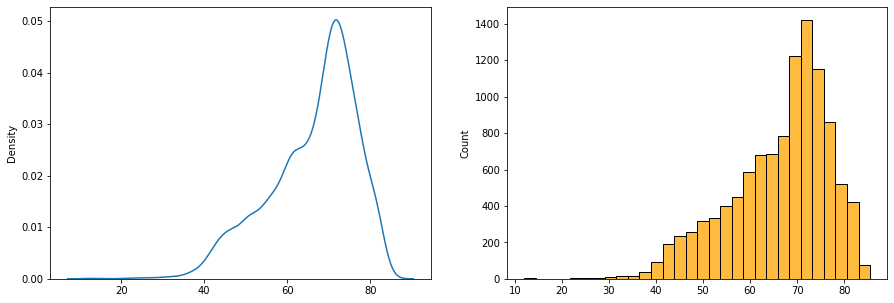

In [173]:
figure, axes = plt.subplots(1, 2, figsize=(15,5))

df_avg_life_ext = df[df['INDICATOR_ID'] == "SP.DYN.LE00.IN"]
df_avg_life_ext.index = range(0, df_avg_life_ext.shape[0])

sns.kdeplot(ax=axes[0], data=df_avg_life_ext['VALUE'].values)
sns.histplot(ax=axes[1], data=df_avg_life_ext['VALUE'].values, bins=30, color='orange')

df_avg_life_ext.head()

Масштабирование данных на основе Z-оценки

In [174]:
scaler_1 = StandardScaler()
df_avg_life_ext_scaled_std = scaler_1.fit_transform(df_avg_life_ext[['VALUE']])
df_avg_life_ext['std'] = df_avg_life_ext_scaled_std
df_avg_life_ext.head()

C:\Users\dturc\AppData\Local\Temp\ipykernel_8100\1415406249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg_life_ext['std'] = df_avg_life_ext_scaled_std


,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,std
0,SP.DYN.LE00.IN,ABW,1970,67.583,0.124396
1,SP.DYN.LE00.IN,ABW,1971,67.975,0.161492
2,SP.DYN.LE00.IN,ABW,1972,68.577,0.218461
3,SP.DYN.LE00.IN,ABW,1973,69.092,0.267197
4,SP.DYN.LE00.IN,ABW,1974,69.503,0.306091


Масштабирование "Mean Normalisation"

In [175]:
class MeanNormalisation:
    def fit(self, param_df):
        self.means = param_df.mean(axis=0)
        maxs = param_df.max(axis=0)
        mins = param_df.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

scaler_2 = MeanNormalisation()
df_avg_life_ext_scaled_mean_norm = scaler_2.fit_transform(df_avg_life_ext[['VALUE']])
df_avg_life_ext['mean_norm'] = df_avg_life_ext_scaled_mean_norm
df_avg_life_ext.head()

C:\Users\dturc\AppData\Local\Temp\ipykernel_8100\2930600730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg_life_ext['mean_norm'] = df_avg_life_ext_scaled_mean_norm


,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,std,mean_norm
0,SP.DYN.LE00.IN,ABW,1970,67.583,0.124396,0.017884
1,SP.DYN.LE00.IN,ABW,1971,67.975,0.161492,0.023217
2,SP.DYN.LE00.IN,ABW,1972,68.577,0.218461,0.031407
3,SP.DYN.LE00.IN,ABW,1973,69.092,0.267197,0.038414
4,SP.DYN.LE00.IN,ABW,1974,69.503,0.306091,0.044005


MinMax-масштабирование

In [176]:
scaler_3 = MinMaxScaler()
df_avg_life_ext_scaled_minmax = scaler_3.fit_transform(df_avg_life_ext[['VALUE']])
df_avg_life_ext['minmax'] = df_avg_life_ext_scaled_minmax
df_avg_life_ext.head()

C:\Users\dturc\AppData\Local\Temp\ipykernel_8100\2041289100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg_life_ext['minmax'] = df_avg_life_ext_scaled_minmax


,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,std,mean_norm,minmax
0,SP.DYN.LE00.IN,ABW,1970,67.583,0.124396,0.017884,0.756273
1,SP.DYN.LE00.IN,ABW,1971,67.975,0.161492,0.023217,0.761606
2,SP.DYN.LE00.IN,ABW,1972,68.577,0.218461,0.031407,0.769796
3,SP.DYN.LE00.IN,ABW,1973,69.092,0.267197,0.038414,0.776803
4,SP.DYN.LE00.IN,ABW,1974,69.503,0.306091,0.044005,0.782395


<AxesSubplot:title={'center':'MinMax scaling'}, ylabel='Density'>

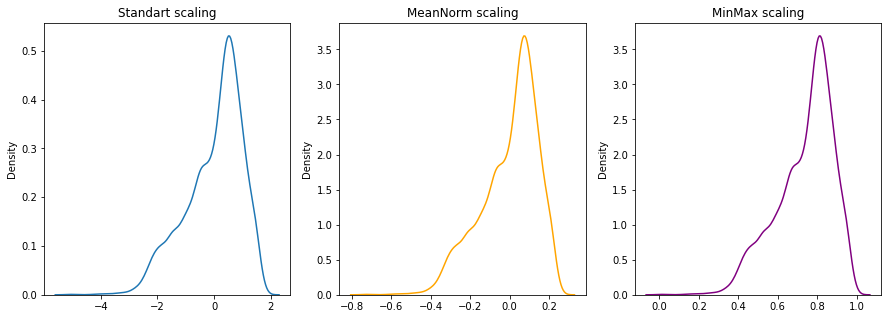

In [177]:
figure, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].set_title('Standart scaling')
sns.kdeplot(ax=axes[0], data=df_avg_life_ext['std'].values)
axes[1].set_title('MeanNorm scaling')
sns.kdeplot(ax=axes[1], data=df_avg_life_ext['mean_norm'].values, color='orange')
axes[2].set_title('MinMax scaling')
sns.kdeplot(ax=axes[2], data=df_avg_life_ext['minmax'].values, color='purple')

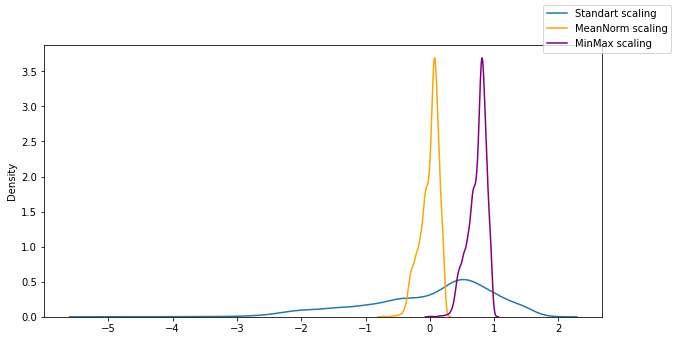

In [178]:
figure, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(ax=ax, data=df_avg_life_ext['std'].values, label='Standart scaling')
sns.kdeplot(ax=ax, data=df_avg_life_ext['mean_norm'].values, color='orange', label='MeanNorm scaling')
sns.kdeplot(ax=ax, data=df_avg_life_ext['minmax'].values, color='purple', label='MinMax scaling')
figure.legend()

### П.2.2. Обработка выбросов для числовых признаков

Выполню обнаружение и замену выбросов на основе 5% и 95% квантилей на выборке со значениями ВВП 

<AxesSubplot:ylabel='Count'>

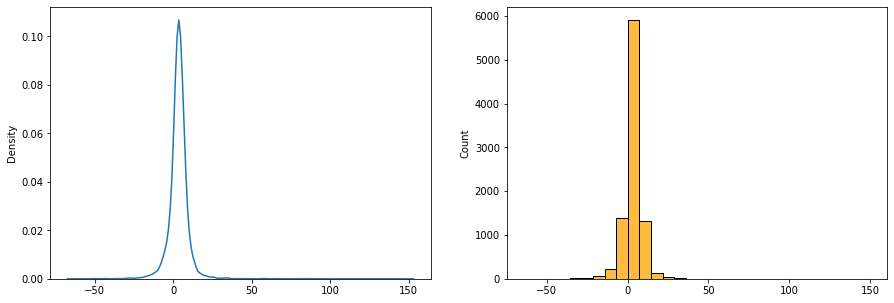

In [179]:
figure, axes = plt.subplots(1, 2, figsize=(15,5))

df_gpd_growth = df[df['INDICATOR_ID'] =="NY.GDP.MKTP.KD.ZG"]
df_gpd_growth.index = range(0, df_gpd_growth.shape[0])

sns.kdeplot(ax=axes[0], data=df_gpd_growth['VALUE'].values)
sns.histplot(ax=axes[1], data=df_gpd_growth['VALUE'].values, bins=30, color='orange')


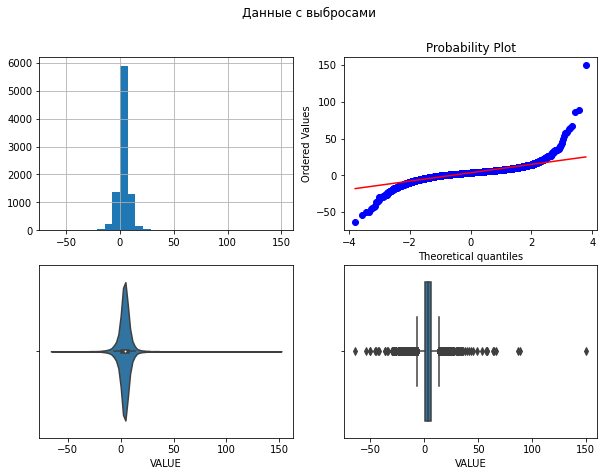

In [180]:
# Графики из лекции
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # скрипичная диаграмма
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

diagnostic_plots(df_gpd_growth, 'VALUE', 'Данные с выбросами')

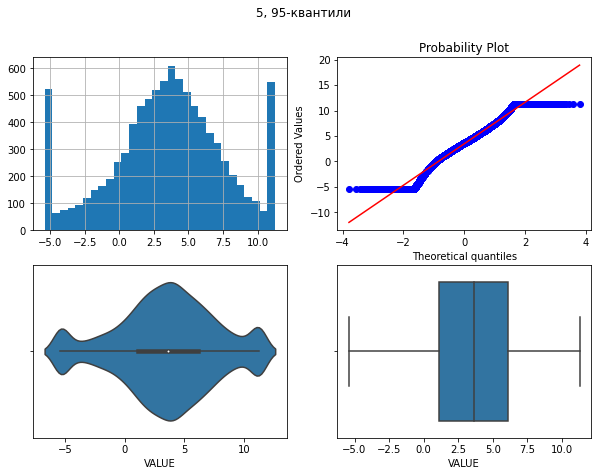

In [181]:
lower_boundary = df_gpd_growth['VALUE'].quantile(0.05)
upper_boundary = df_gpd_growth['VALUE'].quantile(0.95)

df_gpd_growth_outlined = df_gpd_growth.copy()

df_gpd_growth_outlined['VALUE'] = np.where(
  df_gpd_growth_outlined['VALUE'] > upper_boundary, upper_boundary, np.where(
    df_gpd_growth_outlined['VALUE'] < lower_boundary, lower_boundary, df_gpd_growth_outlined['VALUE']
  )
)

diagnostic_plots(df_gpd_growth_outlined, 'VALUE', '5, 95-квантили')

### П.2.3. Обработка нестандартного признака

In [182]:
data_raw_rest = pd.read_csv(data_folder + 'RestaurantDataset .csv')
df_rest = data_raw_rest[['Restaurant ID', 'Restaurant Name', 'Cuisines']]
df_rest = df_rest.dropna(axis='rows', how='any')
df_rest.head()

,Restaurant ID,Restaurant Name,Cuisines
0,6317637,Le Petit Souffle,"French, Japanese, Desserts"
1,6304287,Izakaya Kikufuji,Japanese
2,6300002,Heat - Edsa Shangri-La,"Seafood, Asian, Filipino, Indian"
3,6318506,Ooma,"Japanese, Sushi"
4,6314302,Sambo Kojin,"Japanese, Korean"


In [183]:
df_rest.shape

(9542, 3)

In [184]:
def convert(row):
  # print (row, '=====')
  cuisines_str = row['Cuisines']
  try:
    arr = cuisines_str.split(', ')
    return dict.fromkeys(arr, 1)
  except Exception:
    # Защита от мусора
    # Есть строки с 'nan'
    print(cuisines_str, type(cuisines_str))
    return {}

In [185]:
# df_rest_parsed_cousines = pd.DataFrame(list(map(lambda x: convert(x[1]), df_rest['Cuisines'].items())))
df_rest_parsed_cuisines = pd.DataFrame(df_rest.apply(convert, axis=1).to_list()).fillna(0)
df_rest_parsed_cuisines.head()

,French,Japanese,Desserts,Seafood,Asian,Filipino,Indian,Sushi,Korean,Chinese,...,Patisserie,South African,Durban,Kebab,Turkish Pizza,Izgara,World Cuisine,D�_ner,Restaurant Cafe,B�_rek
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
df_rest_converted = pd.concat([df_rest, df_rest_parsed_cuisines], axis='columns', join='inner')
df_rest_converted.head()

,Restaurant ID,Restaurant Name,Cuisines,French,Japanese,Desserts,Seafood,Asian,Filipino,Indian,...,Patisserie,South African,Durban,Kebab,Turkish Pizza,Izgara,World Cuisine,D�_ner,Restaurant Cafe,B�_rek
0,6317637,Le Petit Souffle,"French, Japanese, Desserts",1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6304287,Izakaya Kikufuji,Japanese,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6300002,Heat - Edsa Shangri-La,"Seafood, Asian, Filipino, Indian",0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6318506,Ooma,"Japanese, Sushi",0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6314302,Sambo Kojin,"Japanese, Korean",0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### П.2.4. Отбор признаков
#### П.2.4.1. filter methods

In [187]:
data_raw_rest.describe()

,Restaurant ID,Country Code,Longitude,Latitude,Average Cost for two,Price range,Aggregate rating,Votes
count,9.551000e+03,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,9.051128e+06,18.365616,64.126574,25.854381,1199.210763,1.804837,2.666370,156.909748
std,8.791521e+06,56.750546,41.467058,11.007935,16121.183073,0.905609,1.516378,430.169145
min,5.300000e+01,1.000000,-157.948486,-41.330428,0.000000,1.000000,0.000000,0.000000
25%,3.019625e+05,1.000000,77.081343,28.478713,250.000000,1.000000,2.500000,5.000000
50%,6.004089e+06,1.000000,77.191964,28.570469,400.000000,2.000000,3.200000,31.000000
75%,1.835229e+07,1.000000,77.282006,28.642758,700.000000,2.000000,3.700000,131.000000
max,1.850065e+07,216.000000,174.832089,55.976980,800000.000000,4.000000,4.900000,10934.000000


Согласно строке std в наборе отсутсвуют числовые признаки с малой дисперсией. Считаем, что констант и псевдоконстант нет.

In [188]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df, level):
    cr = df.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= level]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

make_corr_df(data_raw_rest, 0.3)

,f1,f2,corr
0,Country Code,Longitude,0.698299
1,Longitude,Country Code,0.698299
2,Aggregate rating,Price range,0.437944
3,Price range,Aggregate rating,0.437944
4,Restaurant ID,Aggregate rating,0.326212
5,Aggregate rating,Restaurant ID,0.326212
6,Votes,Aggregate rating,0.313691
7,Aggregate rating,Votes,0.313691
8,Price range,Votes,0.309444
9,Votes,Price range,0.309444


Согласно результату высокий уровень корреляции имеют только Страна и Географическая долгота. Коэффициент корреляции, близкий к 0.5 имеют Рейтинг ресторана и Ценовой диапазон. Коэффициент корреляции около 0.3 имеют Рейтинг ресторана, Ресторан и Ценовой диапазон и Количество оценок.

Можно предположить, что эти признаки формируют 3 группы с уровнями корреляции 0.69, 0.43 и 0.3. Проверим, так ли это.

In [189]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

corr_groups(make_corr_df(data_raw_rest, 0.3))

[['Longitude', 'Country Code'],
 ['Price range', 'Restaurant ID', 'Votes', 'Aggregate rating']]

Имеем две группы коррелирующих признаков.

#### П.2.4.2. wrapper methods

In [190]:
# df_rest_wrap_cols = list(data_raw_rest.columns)
# df_rest_wrap_cols.remove('City')

In [191]:
df_rest_wrap_X = data_raw_rest[['Price range', 'Aggregate rating', 'Votes']] # только числовые
# df_rest_wrap_X = data_raw_rest[df_rest_wrap_cols]
df_rest_wrap_y = data_raw_rest[['City']]

In [192]:
knn = KNeighborsClassifier(n_neighbors=3)

efs1 = EFS(knn, 
           min_features=1,
           max_features=3,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(df_rest_wrap_X, df_rest_wrap_y)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Best accuracy score: 0.27
Best subset (indices): (0, 1, 2)
Best subset (corresponding names): ('Price range', 'Aggregate rating', 'Votes')


Все 3 признака стоит оставить

#### П.2.4.3. embedded methods

Использую датасет из предыдущего пункта, задача классификации.

In [193]:
e_lr1 = LogisticRegression(C=1000, solver='liblinear', penalty='l1', max_iter=500, random_state=1)
e_lr1.fit(df_rest_wrap_X, df_rest_wrap_y)
# Коэффициенты регрессии
e_lr1.coef_

c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 9.00230283e-01,  2.65346401e+00, -1.07764509e-03],
       [ 3.65605665e-01,  2.32276211e+00, -6.59401083e-03],
       [ 7.76284262e-02,  2.25899555e+00,  4.84473770e-05],
       [-4.24174071e-01,  1.49324538e+00, -4.60616366e-03],
       [ 8.75363320e-01,  5.21325588e-01, -7.17603790e-03],
       [-4.36781496e-01,  1.40684197e+00, -9.58079111e-04],
       [ 1.35120382e-01,  3.83285131e+00, -6.20233358e-03],
       [ 1.11258158e-01,  2.07783473e+00, -3.92783499e-02],
       [-1.25486284e+00,  3.08712205e+00,  1.82384770e-04],
       [ 5.61050731e-01,  2.70616699e+00, -7.95276437e-04],
       [-3.83934618e-01,  2.61823752e+00, -2.71670422e-04],
       [ 4.10298590e-01,  7.32388109e-01, -7.12182132e-03],
       [ 4.23396246e-01,  1.01577455e+00, -3.89462678e-02],
       [ 1.43806548e-01,  4.36704394e+00, -8.81313391e-02],
       [-2.03227182e-02,  2.49952968e+00,  7.13789662e-04],
       [-8.82679728e-01,  5.93832736e+00, -3.46352259e-03],
       [-2.16972689e-01,  2.53229040e+00

In [194]:
sel_e_lr1 = SelectFromModel(e_lr1)
sel_e_lr1.fit(df_rest_wrap_X, df_rest_wrap_y)
sel_e_lr1.get_support()

c:\Users\dturc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ True,  True,  True])

Этот метод так же показал, что стоит оставить все 3 признака